## NYC Yellow Taxi Trip Fare Prediction

Submitted By:

**Group 22**

- Adarsh Ajit (24026492)
- Adwaith Thayampara Sasikumar (24108782)
- Parth Badve (24022373)
- Rahul Tummala (24115215)
- Shane Barden (24033944)


In [ ]:
# 1. First ensure proper Drive mounting
from google.colab import drive
drive.flush_and_unmount()  # Clean any existing mounts
drive.mount('/content/drive', force_remount=True)

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import NumericType
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DoubleType
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import hour, avg, dayofweek, count, col, unix_timestamp, sum as spark_sum
from pyspark.ml.feature import VectorAssembler, RobustScaler, StandardScaler, StringIndexer, OneHotEncoder

from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import multiprocessing
import traceback
import sys

# Recreate the SparkSession if it's not active
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/BigDataProject/data'

# 1. Data ingestion and Data cleaning (SparkSQL)




*   Load the chosen dataset (more on this below) into Spark DataFrames.
*   Perform data cleaning (e.g. handling missing values, removing duplicates,handling outliers, etc.).

*   Convert categorical variables into numerical representations, if needed.






In [ ]:
main_df = spark.read.parquet(f"{BASE_PATH}/yellow_tripdata_2022-01.parquet")

In [ ]:
df = main_df

df.limit(15).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-01-01 00:35:40|  2022-01-01 00:53:29|            2.0|          3.8|       1.0|                 N|         142|         236|           1|       14.5|  3.0|    0.5|      3.6

In [ ]:
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



###   This data dictionary describes yellow taxi trip data.
| Field Name           | Description |
|----------------------|-------------|
| VendorID             | A code indicating the TPEP provider that provided the record. <br> 1 = Creative Mobile Technologies, LLC <br> 2 = Curb Mobility, LLC <br> 6 = Myle Technologies Inc <br> 7 = Helix |
| tpep_pickup_datetime | The date and time when the meter was engaged. |
| tpep_dropoff_datetime| The date and time when the meter was disengaged. |
| passenger_count      | The number of passengers in the vehicle. |
| trip_distance        | The elapsed trip distance in miles reported by the taximeter. |
| RatecodeID           | The final rate code in effect at the end of the trip. <br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br> 4 = Nassau or Westchester <br> 5 = Negotiated fare <br> 6 = Group ride <br> 99 = Unknown |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor. <br> Y = store and forward trip <br> N = not a store and forward trip |
| PULocationID         | TLC Taxi Zone in which the taximeter was engaged. |
| DOLocationID         | TLC Taxi Zone in which the taximeter was disengaged. |
| payment_type         | A numeric code signifying how the passenger paid for the trip. <br> 0 = Flex Fare <br> 1 = Credit card <br> 2 = Cash <br> 3 = No charge <br> 4 = Dispute <br> 5 = Unknown <br> 6 = Voided trip |
| fare_amount          | The time-and-distance fare calculated by the meter. |
| extra                | Miscellaneous extras and surcharges. |
| mta_tax              | Tax that is automatically triggered based on the metered rate. |
| tip_amount           | Tip amount — only automatically populated for credit card tips. |
| tolls_amount         | Total amount of all tolls paid in trip. |
| improvement_surcharge | Surcharge added to trips at the flag drop since 2015. |
| total_amount         | Total charged to passengers (does not include cash tips). |
| congestion_surcharge | Total amount collected in trip for NYS congestion. |
| airport_fee          | For pickups only at LaGuardia and JFK. |
| cbd_congestion_fee   | Per-trip charge for MTA’s CBD Congestion Relief Zone (from Jan 5, 2025). |


In [ ]:


# Schema Definition for Better Consistency
schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", IntegerType(), True),
    StructField("DOLocationID", IntegerType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
    StructField("airport_fee", DoubleType(), True),
    StructField("cbd_congestion_fee", DoubleType(), True),
])


In [ ]:

for column in df.columns:
    # Count distinct non-null values only
    distinct_count = df.filter(col(column).isNotNull()) \
                       .select(countDistinct(col(column))).collect()[0][0]
    if distinct_count == 1:
        print(f"'{column}' has a single non-null value and can be considered for removal.")


In [ ]:
df = df.drop("store_and_fwd_flag")

In [ ]:
#  Filter invalid rows
df = df.filter(
    (col("passenger_count") > 0) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("total_amount") > 0) &
    (col("tpep_pickup_datetime").isNotNull()) &
    (col("tpep_dropoff_datetime").isNotNull()) &
    (col("tpep_dropoff_datetime") > col("tpep_pickup_datetime"))
)

In [ ]:
#  Drop duplicates
df = df.dropDuplicates()

### Data Inspection

In [ ]:
df.limit(5).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-01-01 00:46:11|  2022-01-01 00:53:06|            2.0|          0.8|       1.0|         107|         137|           1|        6.5|  3.0|    0.5|      2.05|         0.0|                  0.3|       12.35|                 2.5|     

### Missing Values Analysis

In [ ]:
agg_exprs = [
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]

missing_counts_row = df.agg(*agg_exprs).collect()[0]

missing_counts = {col_name: missing_counts_row[i] for i, col_name in enumerate(df.columns)}

for column, count in missing_counts.items():
    print(f"{column}: {count}")

VendorID: 0
tpep_pickup_datetime: 0
tpep_dropoff_datetime: 0
passenger_count: 0
trip_distance: 0
RatecodeID: 0
PULocationID: 0
DOLocationID: 0
payment_type: 0
fare_amount: 0
extra: 0
mta_tax: 0
tip_amount: 0
tolls_amount: 0
improvement_surcharge: 0
total_amount: 0
congestion_surcharge: 0
airport_fee: 0


There appear to be no obvious missing values. We can further inspect the descriptive statistics to see if there are any hidden missing values.

### Outlier Analysis


In [ ]:
features = [
    'trip_distance',
    'fare_amount',
    'tip_amount',
    'total_amount',
]

payment_mapping = {
    '1': 'Credit Card',
    '2': 'Cash',
    '3': 'No Charge',
    '4': 'Dispute',
    '5': 'Unknown',
    '6': 'Voided Trip'
}

sample_df = df.sample(withReplacement=False, fraction=0.005, seed=42).select(*features).dropna().toPandas()

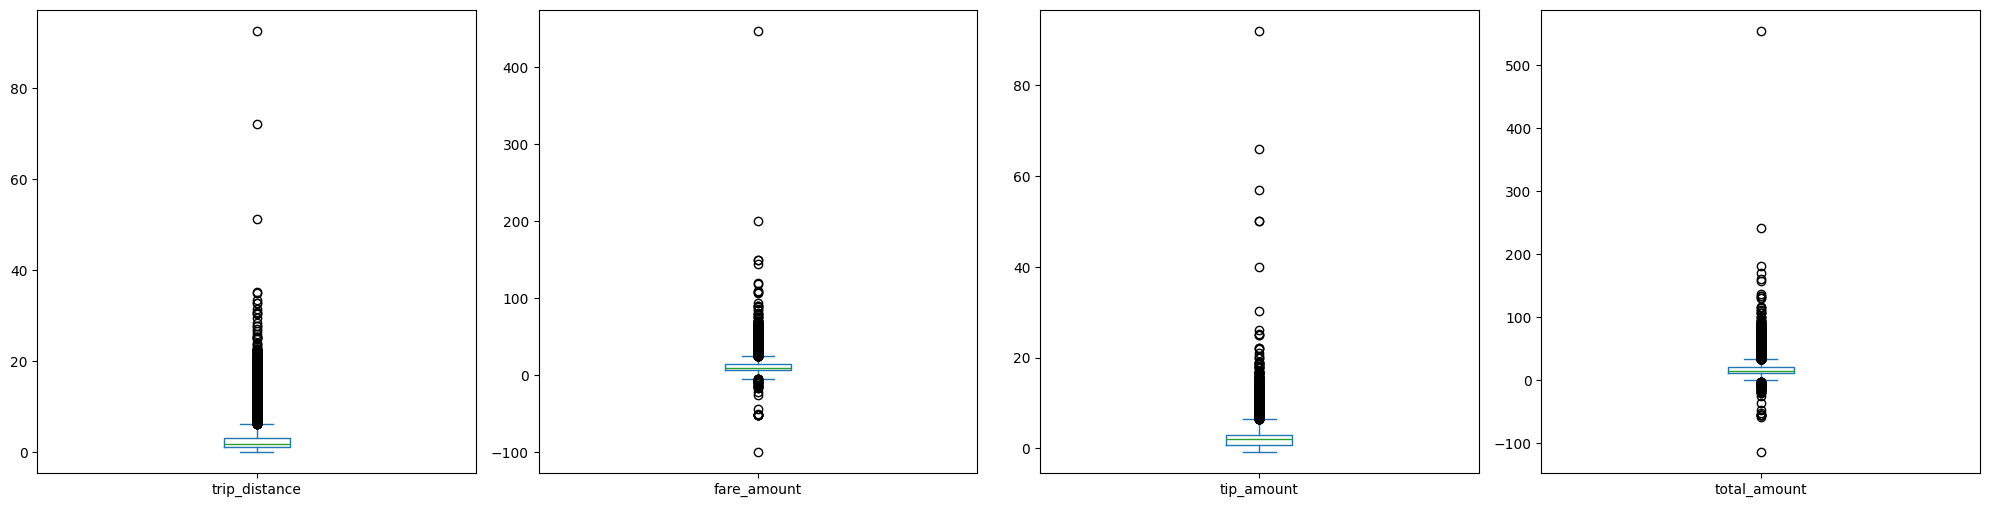

In [ ]:
sample_df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 20))

plt.tight_layout()
plt.show()

##### This shows that we have outlier in our concerned columns
- Extreme outliers are visible in trip_distance, fare_amount, total_amount, and tip_amount.
- Outliers skew the overall data distribution, impacting model accuracy.

In [ ]:
def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = max(0.0, q1 - 1.5 * iqr)
    upper = q3 + 1.5 * iqr
    # print(f"{column}: Keeping values between {lower} and {upper}")
    return df.filter((col(column) >= lower) & (col(column) <= upper))

# Remove outliers from numeric columns
for column in sample_df:
    df = remove_outliers(df, column)

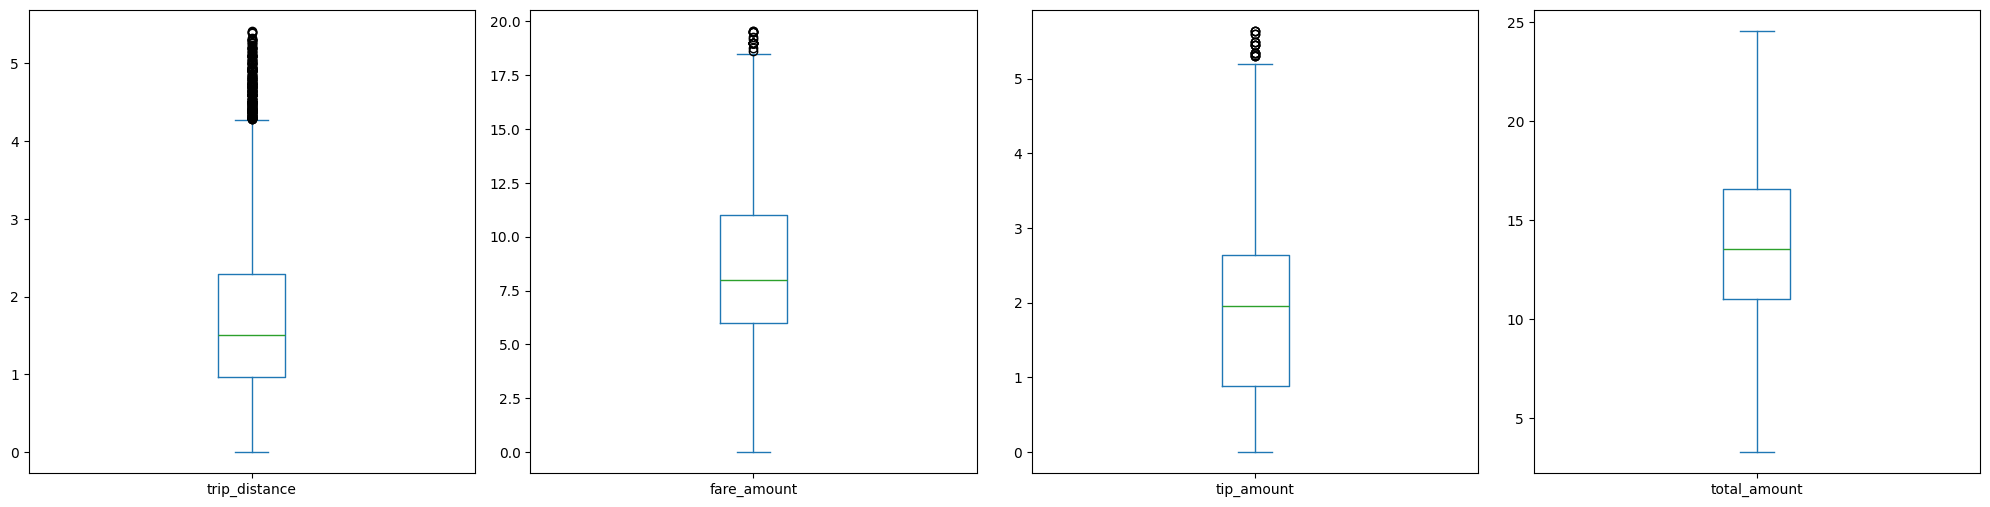

In [ ]:
features = [
    'trip_distance',
    'fare_amount',
    'tip_amount',
    'total_amount',
]

df_numeric = df.sample(withReplacement=False, fraction=0.005, seed=42).select(*features).dropna().toPandas()
df_numeric.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 20))

plt.tight_layout()
plt.show()

##### Outlier mitigation


# 2. Exploratory Data Analysis (EDA)


*   We explore the entire dataset to find meaningful insights.
*   Explore various distributions and summarize the statistics.



## Attribute analysis

### Examination of Numerical Attributes

In [ ]:
# Select numeric columns from the DataFrame and shows their descriptive statistics
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
num_stats_df = df.select(numeric_cols).describe()

num_stats_df.show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------------------+------------------+--------------------+---------------------+------------------+--------------------+--------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|      PULocationID|      DOLocationID|       payment_type|      fare_amount|             extra|             mta_tax|        tip_amount|        tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|         airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------------------+------------------+--------------------+---------------------+------------------+--------------------+--------------------+
|  count|            1

The statistical summary looks fine at a quick glance, indicating no hidden missing values.

Notes on range of values:

- **VendorID**: 1 to 2 (represents the taxi company; only two vendors used)
- **passenger_count**: 1.0 to 9.0 (most taxis typically seat up to 6; values above that may indicate group rides or data errors)
- **trip_distance**: 0.01 to 184340.8 (distance in miles; extremely high maximum suggests outliers or data entry issues)
- **RatecodeID**: 1.0 to 99.0 (standard codes range from 1 to 6; higher values may represent undefined or custom rates)
- **PULocationID**: 1 to 265 (coded pickup zone identifiers)
- **DOLocationID**: 1 to 265 (coded drop-off zone identifiers)
- **payment_type**: 1 to 5 (categorical values representing payment methods such as cash, credit, or voucher)
- **fare_amount**: -22.18 to 401092.32 (fare in USD; negative and extremely high values likely indicate data anomalies)
- **extra**: 0.0 to 33.5 (additional charges such as night or rush hour surcharges)
- **mta_tax**: 0.0 to 0.5 (fixed MTA tax applied per ride)
- **tip_amount**: 0.0 to 1400.16 (optional tip; unusually high values may be outliers)
- **tolls_amount**: 0.0 to 813.75 (tolls incurred during the trip; depends on route and toll roads used)
- **improvement_surcharge**: 0.0 to 1.0 (fixed fee used for taxi improvements)
- **total_amount**: 0.31 to 401095.62 (total paid by customer including all fees, taxes, and tips; max mirrors fare_amount outlier)
- **congestion_surcharge**: 0.0 to 2.75 (fee applied to trips during high-traffic periods or zones)
- **airport_fee**: 0.0 to 1.25 (fixed fee applied for trips to/from airports)




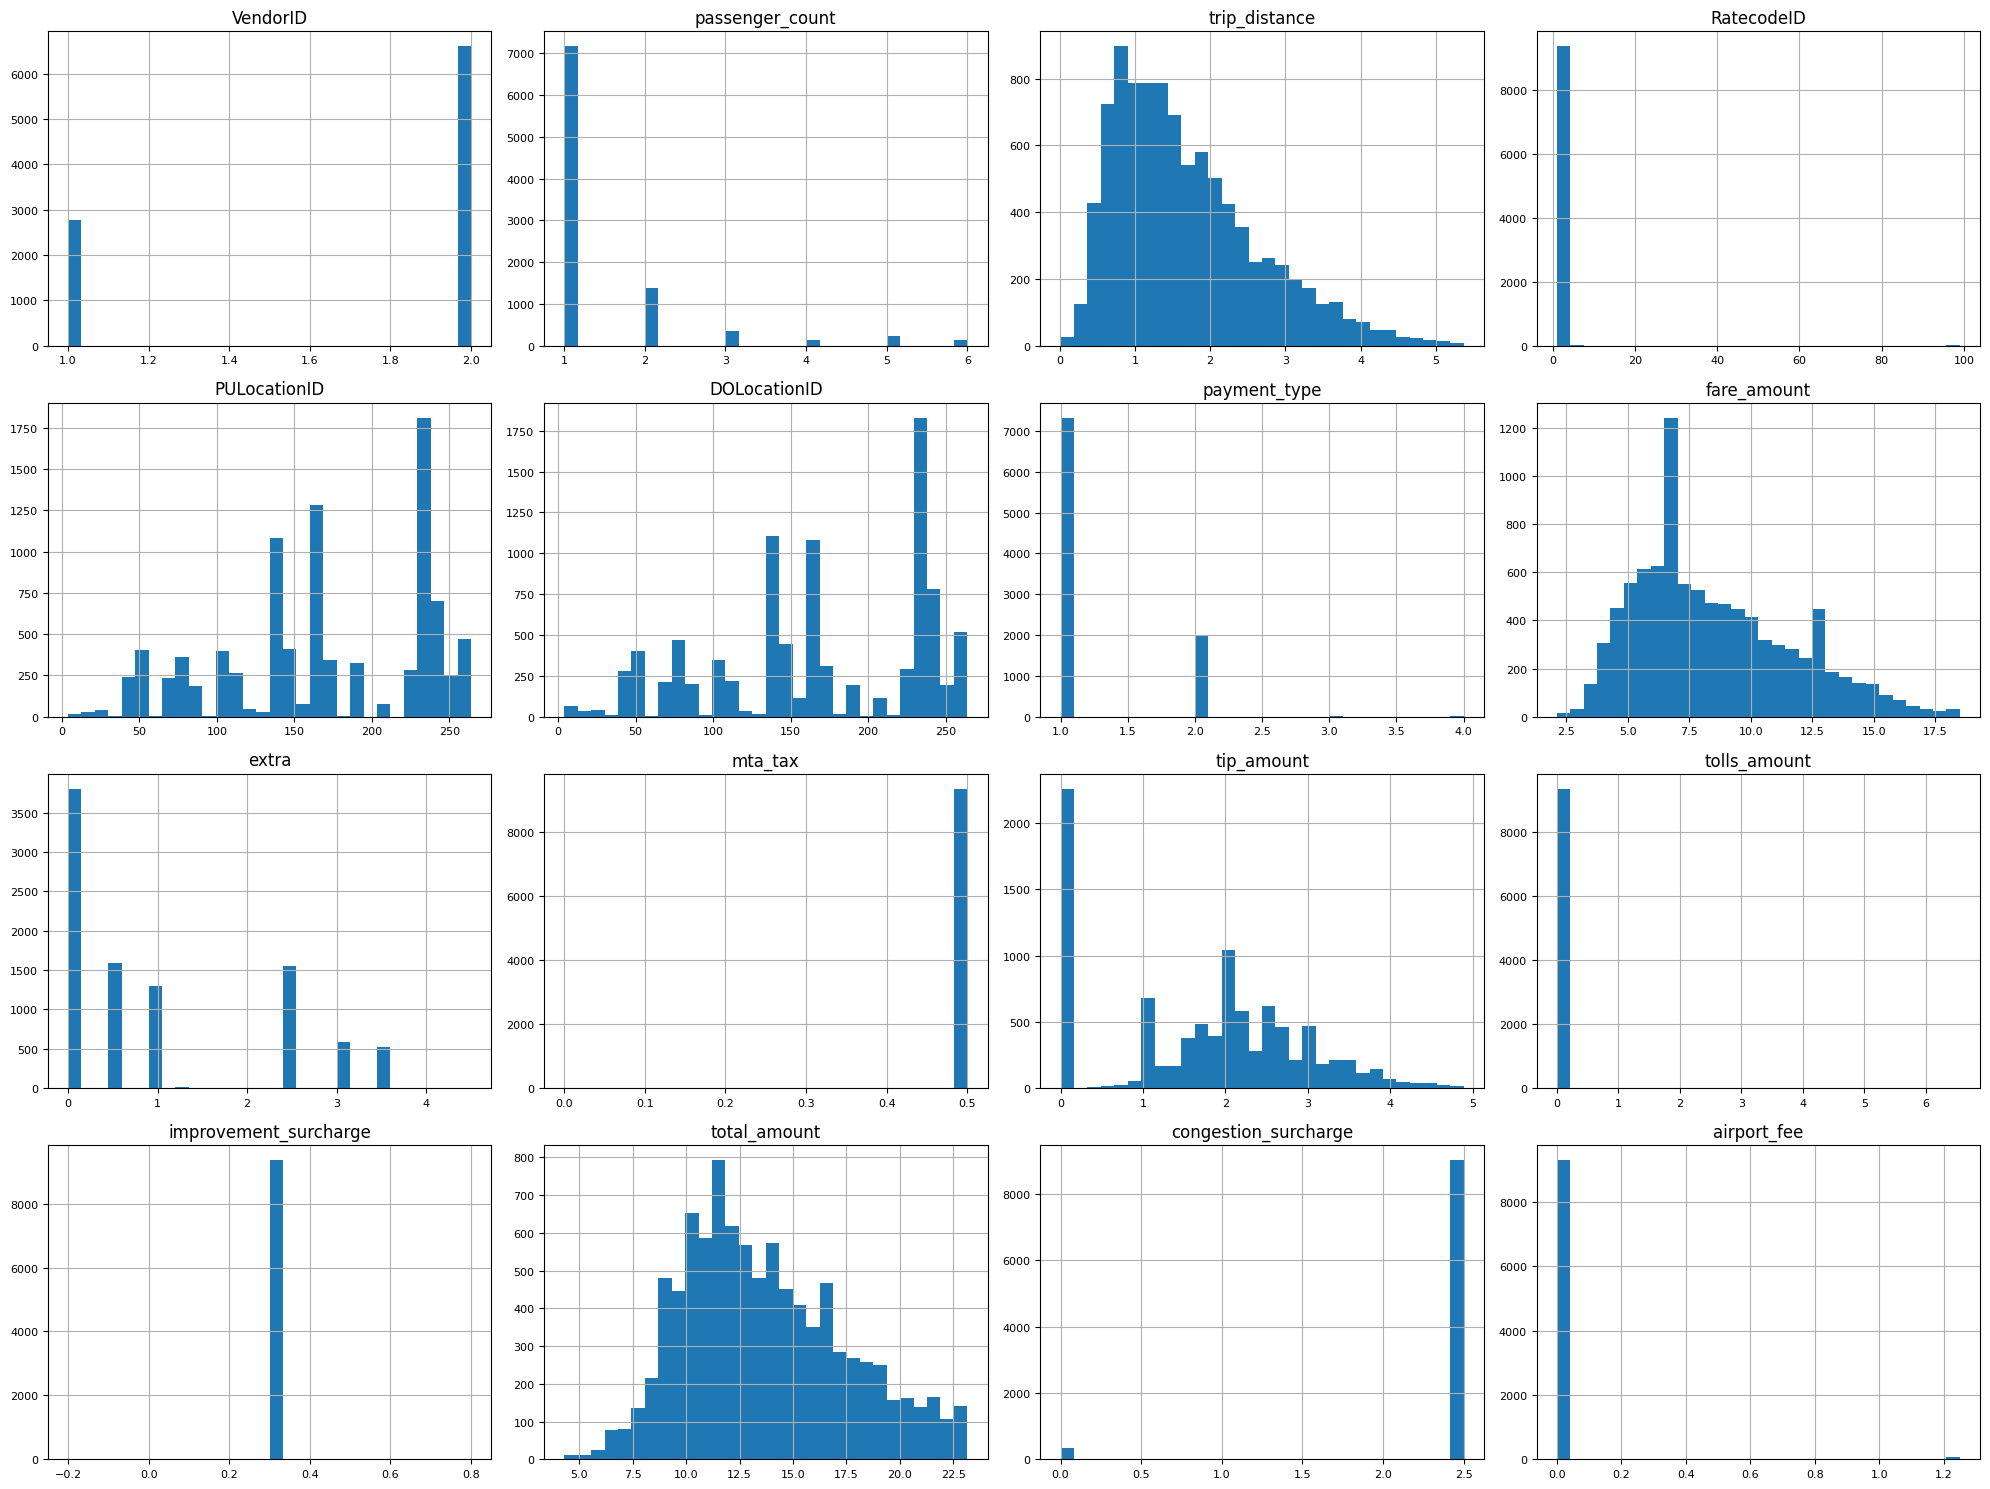

In [ ]:
numeric_col = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

taxi_sample_df = (df.select(numeric_col).sample(fraction=0.1, seed=42).toPandas())

taxi_sample_df.hist(figsize=(20, 15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

The distributions of trip_distance, fare_amount, tip_amount, tolls_amount, and total_amount are right-skewed, indicating that most taxi rides are short and inexpensive, with a few long and high-cost trips creating a long tail.

Most monetary and distance-based features are right-skewed, while the remaining are categorical or fixed-fee related.

### Quick Examination of Categorical Data

In [ ]:
total_payment_types = df.groupBy("payment_type").count()
total_payment_types.show()

+------------+-------+
|payment_type|  count|
+------------+-------+
|           1|1468926|
|           3|   4598|
|           2| 394781|
|           4|   1984|
|           5|      1|
+------------+-------+



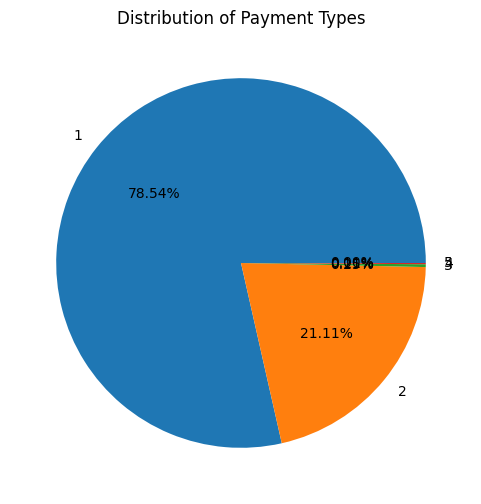

In [ ]:
payment_type_counts = df.groupBy("payment_type").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(6, 6))
plt.pie(payment_type_counts["count"], labels=payment_type_counts["payment_type"], autopct="%.2f%%")
plt.title("Distribution of Payment Types")
plt.show()

In [ ]:
df.groupBy("VendorID").count().show()

+--------+-------+
|VendorID|  count|
+--------+-------+
|       1| 537989|
|       2|1332301|
+--------+-------+



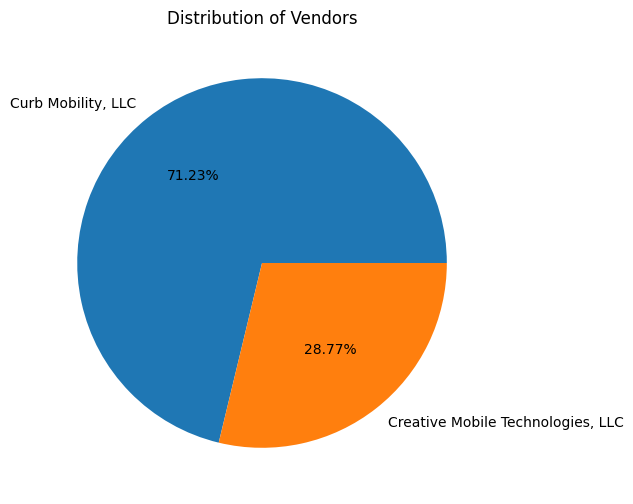

In [ ]:
vendor_labels = {
    1: "Creative Mobile Technologies, LLC",
    2: "Curb Mobility, LLC"
}

vendor_type_counts = df.groupBy("VendorID").count().orderBy("count", ascending=False).toPandas()
vendor_type_counts["VendorID"] = vendor_type_counts["VendorID"].replace(vendor_labels)

plt.figure(figsize=(6, 6))
plt.pie(vendor_type_counts["count"], labels=vendor_type_counts["VendorID"], autopct="%.2f%%")
plt.title("Distribution of Vendors")
plt.show()

In [ ]:
vendor_payment_counts = df.groupBy("VendorID", "payment_type").count().toPandas()

vendor_payment_counts["VendorID"] = vendor_payment_counts["VendorID"].replace(vendor_labels)
vendor_payment_counts["payment_type"] = vendor_payment_counts["payment_type"].replace(payment_mapping)

fig = px.sunburst(
    vendor_payment_counts,
    path=["VendorID", "payment_type"],
    values="count",
    color="payment_type",
    color_discrete_map={
        "Credit Card": "lightblue",
        "Cash": "lightgreen",
        "No Charge": "orange",
        "Dispute": "red",
        "Unknown": "gray",
        "Voided Trip": "purple"
    },
    title="Payment Type Distribution by Vendor"
)

fig.update_traces(
    textinfo="label+percent parent",
    textfont=dict(size=12),
    insidetextorientation="horizontal",
)

fig.update_layout(
    title_font=dict(size=20),
    title_x=0.5,
    title_y=0.95,
    margin=dict(t=50, l=25, r=25, b=25),
    legend_title_text="Payment Type"
)

fig.show()


Inference from the analysis, following are the values which dominate in the category:
- `vendorID`: Curb Mobility, LLC
- `payment_type`: Credit card.

Majority of the customers prefer card payment.

Now we would like to see different insights offerred by the data through a series of targetted questions

### Q1. Trip Time & Duration

#### 1.1. What are the most common pickup and drop-off times throughout the day?

In [ ]:
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df = df.withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))

pickup_counts = df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()
dropoff_counts = df.groupBy("dropoff_hour").count().orderBy("dropoff_hour").toPandas()

fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(x=pickup_counts['pickup_hour'], y=pickup_counts['count'],
                         name='Pickups', marker_color='skyblue'))
fig_bar.add_trace(go.Bar(x=dropoff_counts['dropoff_hour'], y=dropoff_counts['count'],
                         name='Drop-offs', marker_color='salmon'))
fig_bar.update_layout(title='NYC Taxi Trips by Hour of Day',
                      xaxis_title='Hour (0–23)',
                      yaxis_title='Number of Trips',
                      barmode='group',
                      template='plotly_white')
fig_bar.show()


Inference:
- Peak hours of the day are between 6am to 6pm.
- We see a decrease starting from 6pm onwards.
- Highest number of trips are done during the evening.

#### 1.2 How does trip distance vary by hour of the day

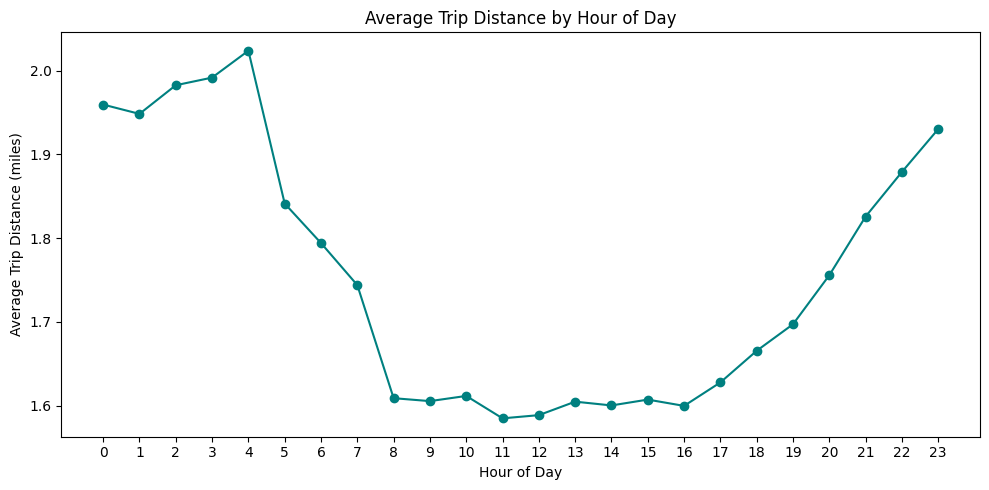

In [ ]:
# Add pickup hour column and compute average distance
avg_distance_by_hour = (df
    .withColumn("hour", hour("tpep_pickup_datetime"))
    .groupBy("hour")
    .agg(avg("trip_distance").alias("avg_distance"))
    .orderBy("hour")
    .toPandas()
)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(avg_distance_by_hour["hour"], avg_distance_by_hour["avg_distance"], marker='o', color='teal')
plt.title("Average Trip Distance by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trip Distance (miles)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Inference:

Trip distances are longest during early morning hours (especially 5–6 AM), indicating airport or inter-neighborhood commutes, and shortest during mid-morning to early afternoon, reflecting local intra-city travel. There’s a secondary rise at night, possibly tied to leisure or return-home travel.

### 1.3 How does trip duration vary across different times of the day?

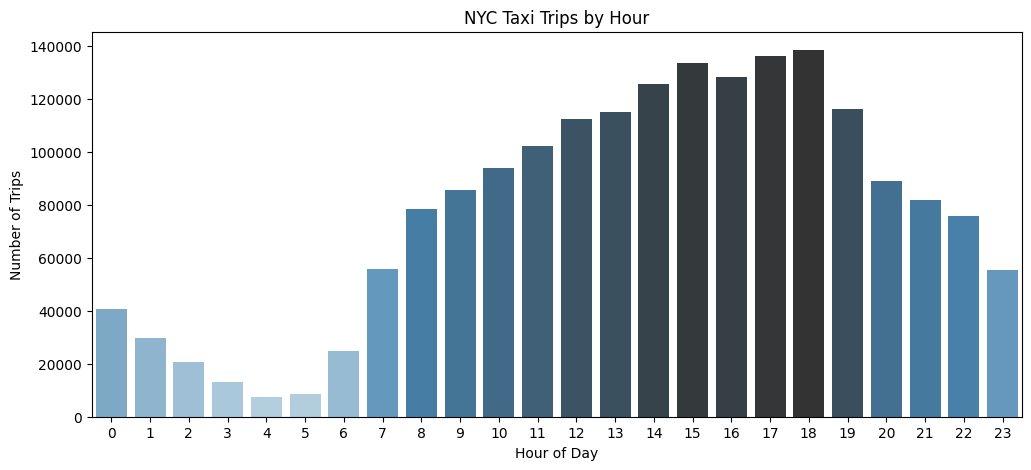

In [ ]:
hourly_counts = (df
                .withColumn("hour", hour("tpep_pickup_datetime"))
                .groupBy("hour")
                .agg(count("*").alias("trips"))
                .orderBy("hour")
                .toPandas())

plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_counts, x="hour", y="trips",
            hue="trips", palette="Blues_d", dodge=False, legend=False)
plt.title("NYC Taxi Trips by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

Inference:

The taxi trips are lowest during early morning hours (midnight to 6 AM), increase sharply from 6 AM, and peak between 2 PM and 6 PM. Trip volume then gradually declines through the evening and night

### 1.4 How does trip duration vary across different days of the week?

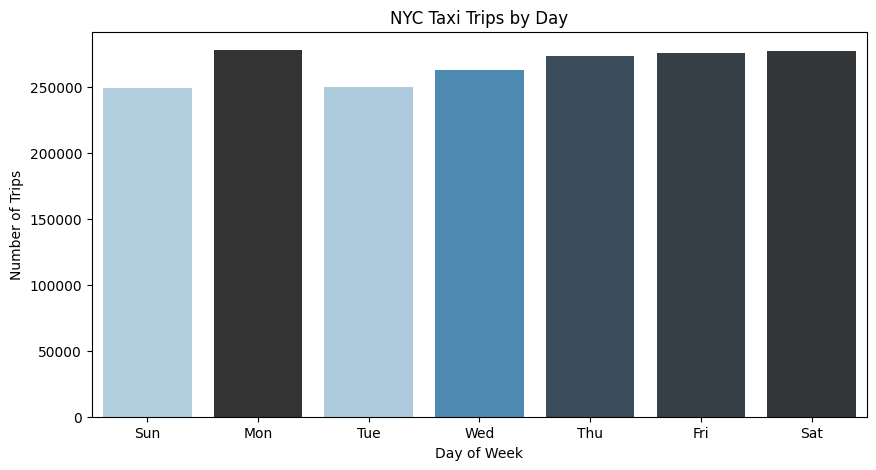

In [ ]:
weekday_counts = (df
                 .withColumn("day", dayofweek("tpep_pickup_datetime"))
                 .groupBy("day")
                 .agg(count("*").alias("trips"))
                 .orderBy("day")
                 .toPandas())

weekday_mapping = {1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed", 5: "Thu", 6: "Fri", 7: "Sat"}

weekday_counts["day_name"] = weekday_counts["day"].map(weekday_mapping)

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_counts, x="day_name", y="trips",
            hue="trips", palette="Blues_d", dodge=False, legend=False)
plt.title("NYC Taxi Trips by Day")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.show()

 Inference:

 We can see that there is a slight dip in the number of trips on Sundays and Tuesdays. Mondays and the weekend, especially Saturday tend to see the highest number of trips.

### Q2. Fare & Tip Analysis

#### 2.1 What is the relationship between trip distance and fare amount?

In [ ]:
df_filtered = df.filter(
    (col("trip_distance") > 0) & (col("trip_distance") < 50) &
    (col("fare_amount") > 0) & (col("fare_amount") < 300)
)

scatter_data = df_filtered.select("trip_distance", "fare_amount").sample(fraction=0.01).toPandas()

fig = px.scatter(
    scatter_data,
    x="trip_distance",
    y="fare_amount",
    trendline="ols",
    title="Trip Distance vs. Fare Amount",
    labels={"trip_distance": "Trip Distance (miles)", "fare_amount": "Fare Amount ($)"},
    opacity=0.6,
    template="plotly_white"
)
fig.update_traces(marker=dict(size=4, color="dodgerblue"))
fig.show()


Inference:

- The fare amount increases linearly with increase in the trip distance.
- There are a few exceptions where fare amount is higher for smaller trips.

#### 2.2 Which days/times see higher tips?

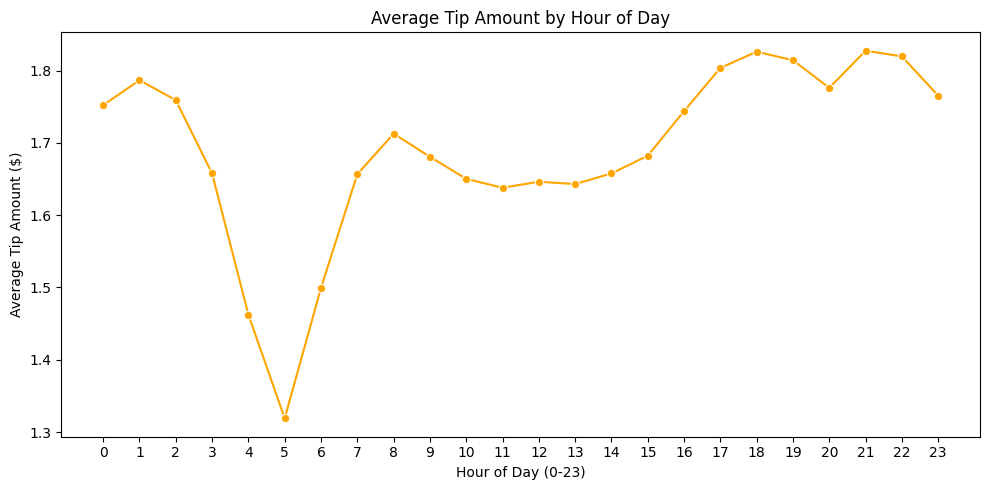

In [ ]:
# Add hour column
df_hourly_tips = df.withColumn("hour", hour("tpep_pickup_datetime"))

# Group by hour and calculate average tip
avg_tips_by_hour = df_hourly_tips.groupBy("hour") \
    .agg(avg("tip_amount").alias("avg_tip")) \
    .orderBy("hour") \
    .toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_tips_by_hour, x="hour", y="avg_tip", marker="o", color="orange")
plt.title("Average Tip Amount by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average Tip Amount ($)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Inference:
- Peak tipping occurs between 17:00 and 22:00 (5 PM to 10 PM), averaging above $1.80, indicating strong tipping behavior during evening travel (commutes, social outings, etc.).

- There is a sharp drop from 3:00 AM to 5:00 AM, hitting the lowest average tip around 5:00 AM (~$1.32). This may reflect shorter rides (e.g., to the airport) or lower rider generosit

- A slight decline occurs after 22:00, though tips still remain higher than early morning values.

## Exploratory Data Analysis (EDA) Summary

**Key Findings:**

* **Strong Fare-Distance Correlation:**  A strong positive correlation exists between `trip_distance` and `fare_amount`, as expected.  Longer trips result in higher fares, a fundamental aspect of taxi pricing.  This relationship was visually confirmed with a regression plot.

* **Fare Components Correlation:**  `fare_amount`, `tip_amount`, `tolls_amount`, and `total_amount` all show strong positive correlations, confirming their expected contributions to the final trip cost.

* **Tip Behavior:**  Tip amounts show moderate correlations with both `trip_distance` and `fare_amount`, indicating longer or more expensive trips tend to receive higher tips.  Interestingly, a heatmap of average tip amounts by hour and day of the week reveals higher tips during late-night hours (12AM-5AM) on Sundays and Mondays, potentially due to late-night activity or service demands.  Lower average tips were observed during midweek.


* **Temporal Patterns:**  The most common pickup and drop-off hours are between 2 PM and 7 PM, with a pronounced peak around 7 PM for drop-offs.  Average trip duration is longest between 3 PM and 5 PM.


**Other Observations:**

* **Payment Type Preference:** Credit card was the most preferred payment type for both taxi vendors.
* **Vendor Comparison:**  The EDA compared trip characteristics across the two major vendors.


## 3. Feature Analysis

In [ ]:
df_sample = df.sample(fraction=0.6)

new_df = df_sample.select(numeric_cols).toPandas()

corr_matrix = new_df.corr()

fig = px.imshow(
    corr_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu',
    zmin=-1, zmax=1,
    title='NYC Taxi Trip Correlation Heatmap'
)

fig.update_layout(width=800, height=800)
fig.show()

## Correlation Heatmap Insights

- The heatmap shows **strong correlations** among various fare-related and total amount features. Notably, **fare_amount**, **tip_amount**, **tolls_amount**, and **total_amount** are all **strongly positively correlated**, which is expected since they all contribute to the total trip cost.

- **Fare_amount** also has a strong positive correlation with **trip_distance**, which aligns with intuition—longer trips generally cost more.

- **Tip_amount** shows moderate positive correlation with **trip_distance** and **fare_amount**, suggesting that longer or more expensive trips tend to receive higher tips.

- **MTA tax**, **improvement_surcharge**, **congestion_surcharge**, and **airport_fee** show minimal variation and tend to have low or no correlation with most other features, likely because they are flat or fixed fees.

- **Passenger_count** has weak or negligible correlations with most other features, indicating that the number of passengers doesn’t strongly influence the trip cost or tip amount.

- **VendorID**, **RatecodeID**, **PULocationID**, and **DOLocationID** show very weak correlations overall, suggesting that vendor or zone IDs are not linearly related to fare components but may influence other factors like route or trip duration not shown here.

- **Payment_type** shows a small negative correlation with **tip_amount**, which may suggest that card payments tend to include tips more often than cash.



In [ ]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_unscaled")
df = assembler.transform(df)

scaler = RobustScaler(inputCol="features_unscaled", outputCol="features_scaled")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

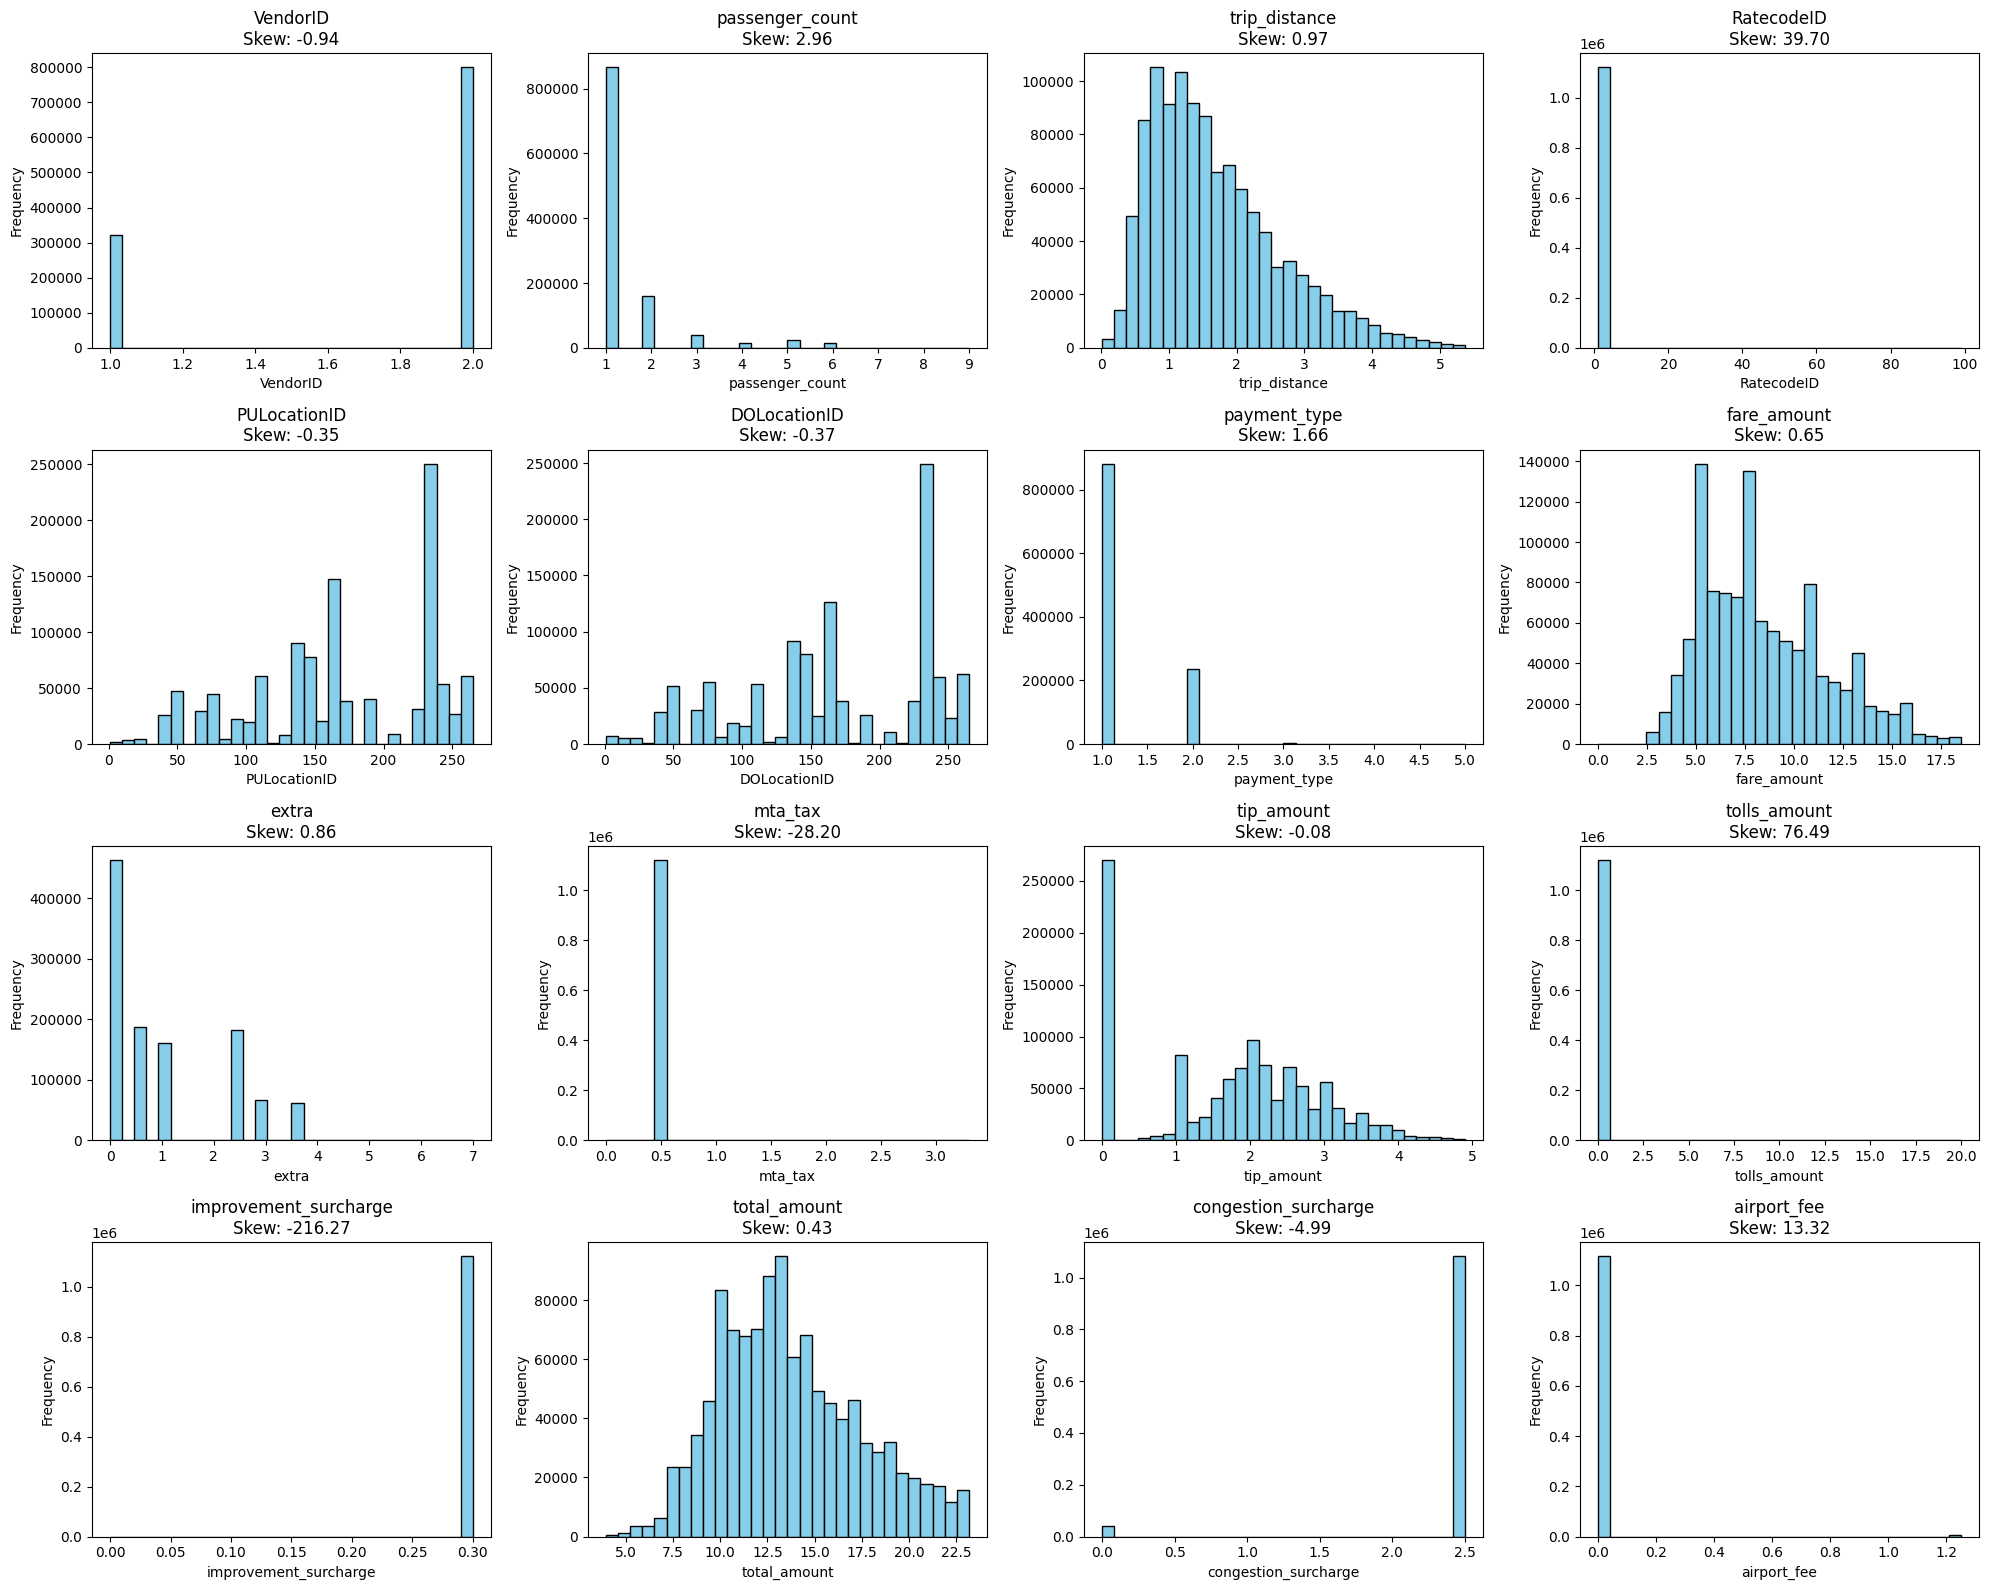

In [ ]:
cols = new_df.columns

n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, column in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(new_df[column].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{column}\nSkew: {new_df[column].skew():.2f}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Looking at above histograms:
- The features like `trip_distance`, `fare_amount`, `tip_total`, `total_amount`, `PULocationID`, `DOLocationID` and `pickup_hour` are of our analysis importance and skewed, so they need to be normalised

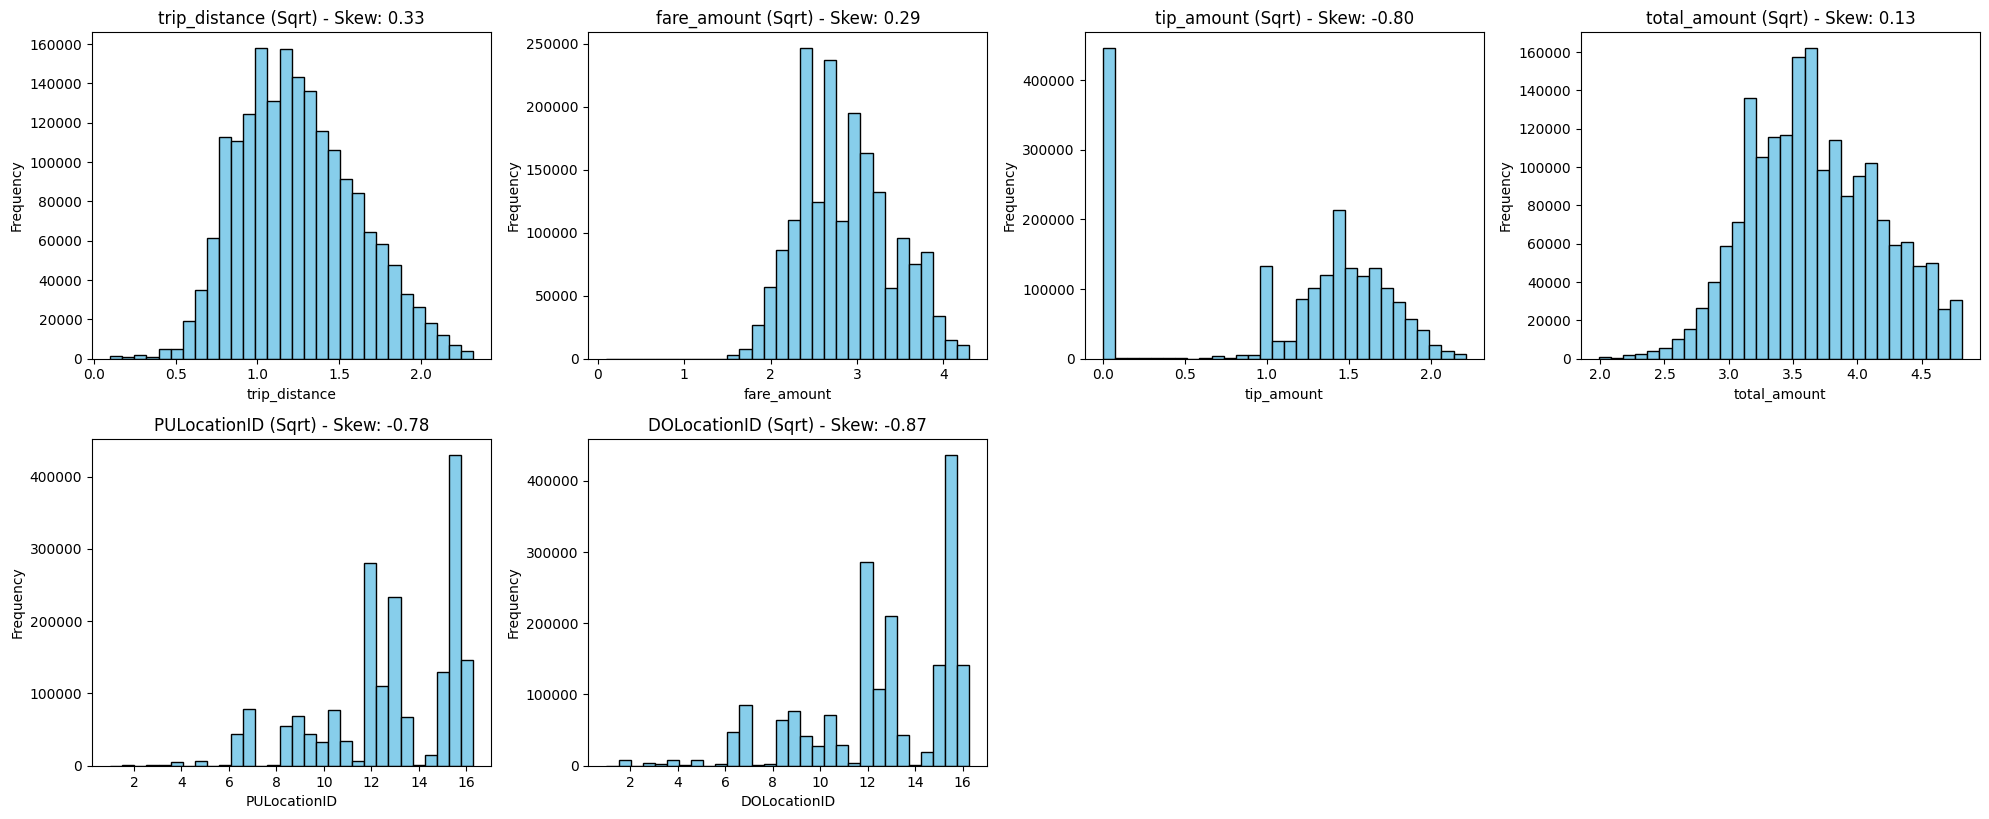

In [ ]:
# Columns to transform
features = [
    'trip_distance',
    'fare_amount',
    'tip_amount',
    'total_amount',
    'PULocationID',
    'DOLocationID',
]

df_normal = df.select(features).toPandas()

for col in features:
    df_normal[col] = np.sqrt(df_normal[col].clip(lower=0))

n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df_normal[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'{col} (Sqrt) - Skew: {df_normal[col].skew():.2f}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 4. Machine Learning Model Implementation (Using SparkML)

Predicting the fare-price based on the pick-up and drop-off location

In [ ]:
df.limit(5).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+-----------------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_hour|dropoff_hour|trip_duration_min|pickup_dayofweek|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+-----------------+----------------+
|       1| 2022-01-01 00:46:11|  2022-01-01 00:53:06|           

###ML Model 1: Decision Tree

In [ ]:
spark.catalog.clearCache()

df_sample = df.sample(withReplacement=False,
                           fraction=0.05,
                           seed=42)
df_filtered = (
    df_sample.filter(
        (col("fare_amount") > 0) & (col("fare_amount") < 200) &
        (col("trip_distance") > 0) & (col("trip_distance") < 100)
    )
)

# Feature engineering
df_feat = (
    df_filtered
      .withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
      .withColumn("pickup_dow",  dayofweek(col("tpep_pickup_datetime")))   # 1 = Sun
)

categorical_cols = ["PULocationID", "DOLocationID", "payment_type"]
numeric_cols      = ["trip_distance", "pickup_hour", "pickup_dow", "passenger_count"]

indexers  = [StringIndexer(inputCol=c, outputCol=f"{c}_idx",
                           handleInvalid="keep")
             for c in categorical_cols]

encoders  = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe",
                           dropLast=True)
             for c in categorical_cols]

assembler = VectorAssembler(
    inputCols=[f"{c}_ohe" for c in categorical_cols] + numeric_cols,
    outputCol="features"
)

In [ ]:
# Decision-tree regressor
dtr = DecisionTreeRegressor(
    labelCol   ="fare_amount",
    featuresCol="features",
    seed       =42
)

pipeline = Pipeline(stages=indexers + encoders + [assembler, dtr])

In [ ]:
# Compact hyper-parameter grid
paramGrid = (
    ParamGridBuilder()
      .addGrid(dtr.maxDepth,           [6, 10])
      .addGrid(dtr.minInstancesPerNode,[5, 15])
      .build()
)

# Cross-validator
NUM_CORES = multiprocessing.cpu_count()

spark = (
    SparkSession.builder
        .master(f"local[{NUM_CORES}]")
        .appName("taxi-dtr-fast")
        .getOrCreate()
)
spark.conf.set("spark.sql.shuffle.partitions", str(NUM_CORES * 2))
spark.conf.set("spark.default.parallelism",    str(NUM_CORES * 2))


evaluator = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="rmse"
)

cv = CrossValidator(
    estimator          =pipeline,
    estimatorParamMaps =paramGrid,
    evaluator          =evaluator,
    numFolds           =3,
    parallelism        =NUM_CORES,
    seed               =42
)

In [ ]:
# Train / test split  & model fitting
train_df, test_df = df_feat.randomSplit([0.8, 0.2], seed=42)

In [ ]:
cv_model = cv.fit(train_df)

In [ ]:
# Best-model parameters
best_model = cv_model.bestModel
best_tree  = best_model.stages[-1]
print("\n••• Best Decision-Tree parameters •••")
print(f"maxDepth           : {best_tree.getMaxDepth()}")
print(f"minInstancesPerNode: {best_tree.getMinInstancesPerNode()}")


••• Best Decision-Tree parameters •••
maxDepth           : 6
minInstancesPerNode: 5


In [ ]:
# Evaluate on held-out test set
preds = best_model.transform(test_df).cache()

rmse_eval = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="rmse"
).evaluate(preds)

r2_eval = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="r2"
).evaluate(preds)

print(f"\nTuned Decision-Tree – Test metrics")
print(f"  RMSE: {rmse_eval:,.2f} ")
print(f"  R2 : {r2_eval:,.2f} ")


#save the best model for reuse

best_model.write().overwrite().save("/FileStore/models/taxi_fare_dtr_best")



Tuned Decision-Tree – Test metrics
  RMSE: 3.17 
  R2 : 0.92 


In [ ]:
 preds.select("fare_amount", "prediction", "trip_distance",
                          "PULocationID", "DOLocationID").limit(5).show()

+-----------+------------------+-------------+------------+------------+
|fare_amount|        prediction|trip_distance|PULocationID|DOLocationID|
+-----------+------------------+-------------+------------+------------+
|        6.0| 5.355126716478191|          0.8|         170|         170|
|       16.0|16.815897435897437|          4.8|          50|         166|
|       12.0|12.603369320737741|          2.9|         239|         162|
|       16.5| 9.795823665893272|          2.5|          68|         170|
|       17.5|16.815897435897437|          5.2|         238|         246|
+-----------+------------------+-------------+------------+------------+



### ML Model 2: Random Forest Regressor


In [ ]:
# Progress tracking function with elapsed time
def log_progress(message, start_time=None):
    """Print a timestamped progress message with optional elapsed time"""
    current_time = datetime.now()
    time_str = current_time.strftime("%H:%M:%S")

    if start_time:
        elapsed = current_time - start_time
        elapsed_min = elapsed.total_seconds() / 60
        print(f"[{time_str}] {message} (Elapsed: {elapsed_min:.2f} minutes)")
    else:
        print(f"[{time_str}] {message}")

    return current_time

# Main function to handle the Spark pipeline
def run_taxi_fare_model():
    start_time = log_progress("Starting optimized Spark ML pipeline with EDA-important features")

    # Check if Spark session exists and create one if needed
    try:
        # First try to use existing spark session
        log_progress("Checking existing Spark session", start_time)
        _ = spark.sparkContext.appName
        log_progress(f"Using existing Spark session: {spark.sparkContext.appName}", start_time)
    except:
        # If that fails, create a new one
        log_progress("Creating new Spark session", start_time)
        spark = SparkSession.builder \
            .appName("TaxiFarePrediction") \
            .config("spark.sql.shuffle.partitions", "100") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "4g") \
            .getOrCreate()

        # Make spark available in global scope
        globals()['spark'] = spark

    try:
        # After ensuring a Spark session, proceed with the model
        log_progress("Spark session confirmed", start_time)

        # Get original data size
        try:
            total_count = df.count()
            log_progress(f"Original dataset size: {total_count} rows", start_time)
        except:
            log_progress("Could not count original dataset (may be too large)", start_time)

        # Use 20% sample for an optimal balance of data representation and processing time
        sample_fraction = 0.20
        log_progress(f"Sampling {sample_fraction*100}% of data", start_time)

        try:
            sampled_df = df.sample(fraction=sample_fraction, seed=42)
            sampled_count = sampled_df.count()
            log_progress(f"Successfully sampled {sampled_count} rows", start_time)
        except Exception as e:
            log_progress(f"Error during sampling: {str(e)}", start_time)
            log_progress("Falling back to 10% sample", start_time)
            sample_fraction = 0.10  # Fallback to 10%
            sampled_df = df.sample(fraction=sample_fraction, seed=42)
            sampled_count = sampled_df.count()
            log_progress(f"Successfully sampled {sampled_count} rows with 10% fraction", start_time)

        # Feature engineering using only features noted as important in EDA
        log_progress("Performing feature engineering with EDA-important features", start_time)

        # Extract hour from pickup time (noted as important in EDA)
        df_processed = sampled_df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

        # Use only the features specifically mentioned as important in the EDA
        # From EDA: "trip_distance, fare_amount, PULocationID, DOLocationID and pickup_hour are of our analysis importance"
        categorical_cols = ["PULocationID", "DOLocationID"]  # Important location features from EDA
        numeric_cols = ["trip_distance", "pickup_hour"]      # Important numeric features from EDA

        log_progress(f"Using features highlighted in EDA: {categorical_cols + numeric_cols}", start_time)

        # Create indexers and encoders
        indexers = [StringIndexer(inputCol=c, outputCol=c+"_indexed", handleInvalid="keep")
                   for c in categorical_cols]

        encoders = [OneHotEncoder(inputCol=c+"_indexed", outputCol=c+"_encoded", dropLast=True)
                   for c in categorical_cols]

        # Create feature vector
        encoded_cols = [c+"_encoded" for c in categorical_cols]
        assembler = VectorAssembler(inputCols=encoded_cols + numeric_cols, outputCol="features")

        # Split data
        log_progress("Splitting data into train/test sets", start_time)
        train_data, test_data = df_processed.randomSplit([0.7, 0.3], seed=42)

        # Configure RandomForest with optimized settings
        log_progress("Configuring RandomForest model", start_time)
        rf = RandomForestRegressor(
            featuresCol="features",
            labelCol="fare_amount",
            numTrees=20,            # Moderate number of trees
            maxDepth=8,             # Moderate depth
            maxBins=16,             # Moderate bins
            minInstancesPerNode=10, # Default value
            seed=42,
            cacheNodeIds=False,     # Avoid caching to save memory
            subsamplingRate=0.7     # Standard subsampling rate
        )

        # Build pipeline
        pipeline_stages = indexers + encoders + [assembler, rf]
        pipeline = Pipeline(stages=pipeline_stages)

        # Train with hyperparameter tuning
        log_progress("Setting up hyperparameter tuning", start_time)

        # Define evaluator
        evaluator = RegressionEvaluator(
            labelCol="fare_amount",
            predictionCol="prediction",
            metricName="rmse"
        )

        # Hyperparameter grid
        param_grid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 50, 100]) \
            .addGrid(rf.maxDepth, [8, 10]) \
            .build()

        log_progress(f"Parameter grid contains {len(param_grid)} combinations", start_time)

        # Use TrainValidationSplit for efficient tuning
        tvs = TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=evaluator,
            trainRatio=0.8,  # 80% training, 20% validation
            seed=42
        )

        # Train model with tuning
        log_progress("===== STARTING MODEL TRAINING WITH TUNING =====", start_time)
        log_progress(f"Training will test {len(param_grid)} parameter combinations", start_time)
        training_start = datetime.now()

        tvs_model = tvs.fit(train_data)

        training_end = datetime.now()
        training_duration = training_end - training_start
        training_minutes = training_duration.total_seconds() / 60
        log_progress(f"===== TRAINING COMPLETED in {training_minutes:.2f} minutes =====", start_time)

        # Get best model
        best_model = tvs_model.bestModel

        # Extract parameter values safely
        try:
            # Try to access parameters in the safest way possible
            rf_model = best_model.stages[-1]
            rf_params = rf_model.extractParamMap()

            # Get parameter info using string representations
            log_progress("Best model parameters:", start_time)
            for param, value in rf_params.items():
                if "numTrees" in str(param):
                    log_progress(f"Number of trees: {value}", start_time)
                elif "maxDepth" in str(param):
                    log_progress(f"Max depth: {value}", start_time)

            # If we couldn't find the parameters in the extracted map, report the default values
            if not any("numTrees" in str(p) for p in rf_params.keys()):
                log_progress(f"Number of trees: {rf.getNumTrees()} (default)", start_time)
            if not any("maxDepth" in str(p) for p in rf_params.keys()):
                log_progress(f"Max depth: {rf.getMaxDepth()} (default)", start_time)

        except Exception as e:
            log_progress(f"Could not extract model parameters: {str(e)}", start_time)
            log_progress("Using default parameters for reporting", start_time)
            log_progress(f"Default number of trees: {rf.getNumTrees()}", start_time)
            log_progress(f"Default max depth: {rf.getMaxDepth()}", start_time)

        # Feature importance analysis
        log_progress("Extracting feature importance", start_time)
        best_rf = best_model.stages[-1]
        importances = best_rf.featureImportances
        feature_names = encoded_cols + numeric_cols
        feature_importance = [(feature, float(importance)) for feature, importance in zip(feature_names, importances)]
        feature_importance.sort(key=lambda x: x[1], reverse=True)

        log_progress("Feature importance ranking of EDA-important features:", start_time)
        for feature, importance in feature_importance:
            log_progress(f"  - {feature}: {importance:.4f}", start_time)

        # Evaluate model
        log_progress("Evaluating model on test data", start_time)
        predictions = best_model.transform(test_data)

        # Calculate metrics
        rmse = evaluator.evaluate(predictions)
        r2 = evaluator.setMetricName("r2").evaluate(predictions)
        mae = evaluator.setMetricName("mae").evaluate(predictions)

        log_progress("Model performance metrics:", start_time)
        log_progress(f"RMSE: {rmse:.4f}", start_time)
        log_progress(f"R2: {r2:.4f}", start_time)
        log_progress(f"MAE: {mae:.4f}", start_time)

        # Show sample predictions
        log_progress("Sample predictions:", start_time)
        predictions.select("fare_amount", "prediction", "trip_distance",
                          "PULocationID", "DOLocationID", "pickup_hour").limit(5).show()

        # Save the model
        model_path = "./taxi_fare_model_eda_features"
        log_progress(f"Saving model to {model_path}", start_time)
        best_model.write().overwrite().save(model_path)

        # Summary
        log_progress("====== OPTIMIZATION SUMMARY ======", start_time)
        log_progress(f"Dataset: {sample_fraction*100}% of original data ({sampled_count} rows)", start_time)
        log_progress(f"Feature selection directly from EDA:", start_time)
        log_progress(f"  - trip_distance: Strong correlation with fare_amount", start_time)
        log_progress(f"  - PULocationID/DOLocationID: Important location features", start_time)
        log_progress(f"  - pickup_hour: Important temporal feature", start_time)
        log_progress(f"Hyperparameter tuning: {len(param_grid)} combinations tested", start_time)
        log_progress(f"Performance: RMSE={rmse:.4f}, R2={r2:.4f}, MAE={mae:.4f}", start_time)
        log_progress("==============================", start_time)

    except Exception as e:
        log_progress(f"Error: {str(e)}", start_time)
        traceback.print_exc()

    finally:
        # Cleanup
        log_progress("Cleaning up resources", start_time)
        try:
            spark.catalog.clearCache()
        except:
            log_progress("Could not clear cache", start_time)

        # Calculate total runtime
        total_runtime = datetime.now() - start_time
        total_minutes = total_runtime.total_seconds() / 60
        log_progress(f"Total runtime: {total_minutes:.2f} minutes", start_time)

# Call the main function
run_taxi_fare_model()

[13:05:54] Starting optimized Spark ML pipeline with EDA-important features
[13:05:54] Checking existing Spark session (Elapsed: 0.00 minutes)
[13:05:54] Creating new Spark session (Elapsed: 0.00 minutes)
[13:05:54] Spark session confirmed (Elapsed: 0.00 minutes)
[13:06:10] Original dataset size: 2301872 rows (Elapsed: 0.27 minutes)
[13:06:10] Sampling 20.0% of data (Elapsed: 0.27 minutes)
[13:06:23] Successfully sampled 461345 rows (Elapsed: 0.49 minutes)
[13:06:23] Performing feature engineering with EDA-important features (Elapsed: 0.49 minutes)
[13:06:23] Using features highlighted in EDA: ['PULocationID', 'DOLocationID', 'trip_distance', 'pickup_hour'] (Elapsed: 0.49 minutes)
[13:06:24] Splitting data into train/test sets (Elapsed: 0.50 minutes)
[13:06:24] Configuring RandomForest model (Elapsed: 0.50 minutes)
[13:06:24] Setting up hyperparameter tuning (Elapsed: 0.50 minutes)
[13:06:24] Parameter grid contains 6 combinations (Elapsed: 0.50 minutes)
[13:06:24] ===== STARTING MODEL

### ML Model 3: Linear regression with L1 regularization

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Taxi Fare Prediction") \
    .getOrCreate()

# Feature engineering and model building
def build_linear_regression_model(df_processed, reg_type="linear", reg_param=0.0):
    # Define feature columns
    feature_cols = ["trip_distance", "pickup_hour", "dropoff_hour", "PULocationID", "DOLocationID"]

    # Create a VectorAssembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

    # Add StandardScaler for better model performance
    scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

    # Create a Linear Regression model
    # For Lasso (L1), set elasticNetParam=1.0 and regParam to desired value
    # For Ridge (L2), set elasticNetParam=0.0 and regParam to desired value
    # For standard Linear Regression, set regParam=0.0
    if reg_type == "lasso":
        lr = LinearRegression(
            featuresCol="features",
            labelCol="fare_amount",
            maxIter=100,
            regParam=reg_param,    # L1 regularization strength
            elasticNetParam=1.0,   # 1.0 for Lasso (L1)
            standardization=False  # Already standardized by StandardScaler
        )
    else:  # standard linear regression
        lr = LinearRegression(
            featuresCol="features",
            labelCol="fare_amount",
            maxIter=100,
            regParam=0.0,          # No regularization
            elasticNetParam=0.0,   # 0.0 for standard linear regression
            standardization=False  # Already standardized by StandardScaler
        )

    # Split data into training and testing sets
    train_data, test_data = df_processed.randomSplit([0.7, 0.3], seed=42)

    # Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    # Train the model
    model = pipeline.fit(train_data)

    # Free up memory
    train_data.unpersist()

    # Make predictions on test data
    predictions = model.transform(test_data)

    return model, predictions, test_data

# Evaluate model performance
def evaluate_model(predictions, label_col="fare_amount", prediction_col="prediction"):
    # Calculate RMSE
    evaluator_rmse = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="rmse"
    )
    rmse = evaluator_rmse.evaluate(predictions)

    # Calculate MAE
    evaluator_mae = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="mae"
    )
    mae = evaluator_mae.evaluate(predictions)

    # Calculate R-squared
    evaluator_r2 = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="r2"
    )
    r2 = evaluator_r2.evaluate(predictions)

    return {"RMSE": rmse, "MAE": mae, "R-squared": r2}

In [ ]:
# Build and train Linear Regression model
print("Training Linear Regression model...")
linear_model, linear_predictions, test_data = build_linear_regression_model(df, reg_type="linear")

# Evaluate Linear Regression model
linear_metrics = evaluate_model(linear_predictions)

# Display Linear Regression evaluation metrics
print("\nLinear Regression Model Evaluation Metrics:")
for metric, value in linear_metrics.items():
    print(f"{metric}: {value}")

# Build and train Lasso Regression model
print("\nTraining Lasso Regression model...")
lasso_model, lasso_predictions, _ = build_linear_regression_model(df, reg_type="lasso", reg_param=0.1)

# Evaluate Lasso Regression model
lasso_metrics = evaluate_model(lasso_predictions)

# Display Lasso Regression evaluation metrics
print("\nLasso Regression Model Evaluation Metrics:")
for metric, value in lasso_metrics.items():
    print(f"{metric}: {value}")

# Show sample predictions from Lasso model
print("\nSample Predictions (Lasso):")
lasso_predictions.select("fare_amount", "prediction", "trip_distance").show(10)

# Extract coefficients from the Lasso model
lasso_coefficients = lasso_model.stages[-1].coefficients

# Get feature names
feature_names = ["trip_distance", "pickup_hour", "pickup_day", "PULocationID", "DOLocationID"]

# Display feature importance
print("\nLasso Model Coefficients:")
for feature, coef in zip(feature_names, lasso_coefficients):
    print(f"{feature}: {coef}")

In [ ]:
sample_lr = linear_predictions.select("fare_amount", "prediction").sample(False, 0.01, seed=1).toPandas()
sample_lasso = lasso_predictions.select("fare_amount", "prediction").sample(False, 0.01, seed=1).toPandas()

# Linear Plot
plt.figure(figsize=(6,5))
plt.scatter(sample_lr["fare_amount"], sample_lr["prediction"], alpha=0.3, color = "blue")
plt.plot([sample_lr["fare_amount"].min(), sample_lr["fare_amount"].max()],
         [sample_lr["fare_amount"].min(), sample_lr["fare_amount"].max()], 'r--')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.grid(True)
plt.tight_layout()
plt.show()

# Lasso Plot
plt.figure(figsize=(6,5))
plt.scatter(sample_lasso["fare_amount"], sample_lasso["prediction"], alpha=0.3, color='purple')
plt.plot([sample_lasso["fare_amount"].min(), sample_lasso["fare_amount"].max()],
         [sample_lasso["fare_amount"].min(), sample_lasso["fare_amount"].max()], 'r--')
plt.title("Lasso Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.grid(True)
plt.tight_layout()
plt.show()
